**Kaggle's competition** -
https://www.kaggle.com/competitions/titanic/data

**Goal** - with most accuracy predict with the greatest accuracy whether the passenger survive or not

In first I want to do:
1. Load the dataset and explore it
2. Preprocess the dataset, scale the features, remove data emissions, fill or remove data gaps
3. Build the baseline. I think that will be KNN-classifier.

Import the libs

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [15]:
!git clone https://github.com/konstantin-larin/titanic.git

Cloning into 'titanic'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 141.48 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Load dataset

In [16]:
%cd titanic

base = 'data/'
data_train, X_test, y_test = pd.read_csv(base + 'train.csv'), pd.read_csv(base + 'test.csv'), pd.read_csv(base + 'gender_submission.csv')
X_train, y_train = data_train.drop(columns=['Survived']), data_train['Survived']

/content/titanic/titanic


Let's look on data

In [17]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What we have seen? Let's describe the columns:
1. 'PassengerId' we can remove from train cause it doesn't affect on target
2. 'Survived' - is our target. We see that most did not survive
3. Pclass shows the socio-enonomic class. 3rd is lower class, so there are most of them here. That feature is important, because most of survived - is 1st class. We should explore this.
4. Name - we can drop.
5. Sex - is important. Womans were the first to be rescued.
6. Age - is good feature. Children were the first to be rescued. Also I see that this feature has gaps.
7. SibSp defines relations
8. Parch defines relations too
9. Ticket - i don't know how rate this feature, so for now I skip it
10. Fare - skip
11. Cabin - for now skip
12. Embarked - skip

Explore the Pclass

In [19]:
print(data_train.groupby('Pclass')['Survived'].agg(['count', 'mean']))

        count      mean
Pclass                 
1         216  0.629630
2         184  0.472826
3         491  0.242363


So we see, that:
Those who are higher in the class are more likely to survive.

For knn-classifier I prefer to use one-hot encoding for this feature (for all categorial features)

Explore the gender

In [20]:
print(data_train.groupby('Sex')['Survived'].agg(['count', 'mean']))

        count      mean
Sex                    
female    314  0.742038
male      577  0.188908


women had a high chance of survival

explore the age

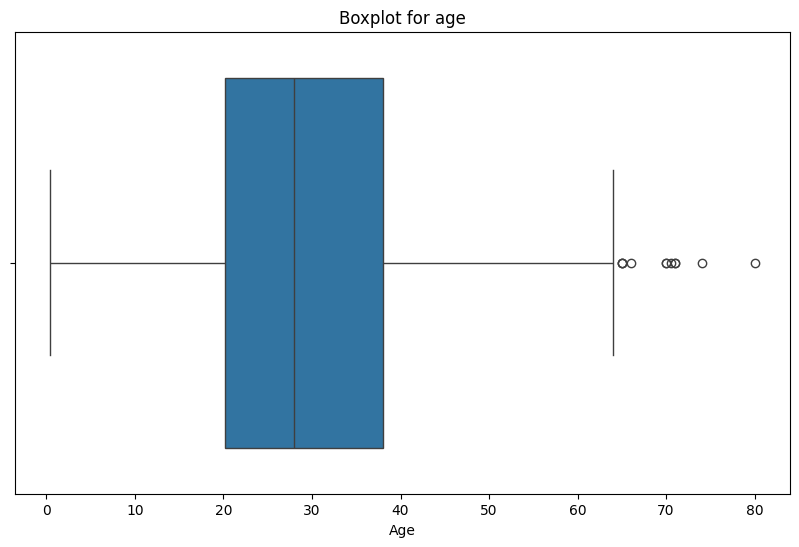

gaps count 177


Text(0, 0.5, 'count')

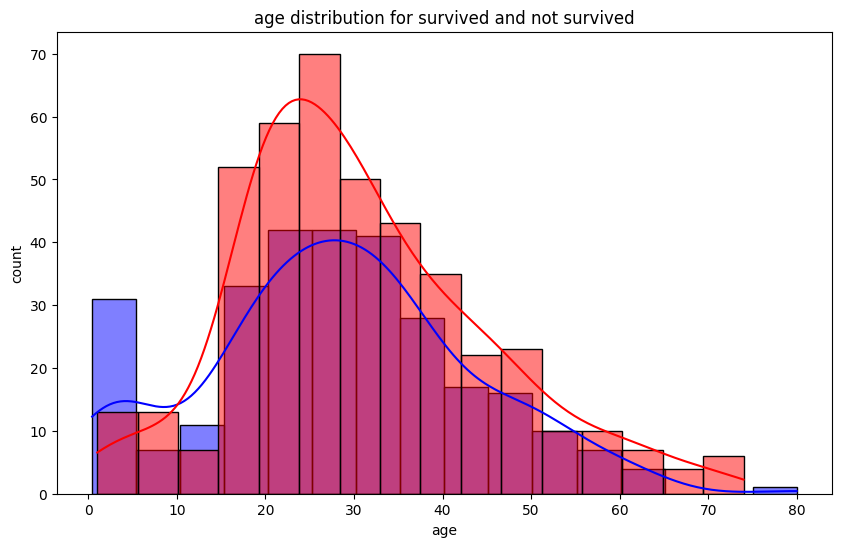

In [21]:
# check on data emissions
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_train['Age'])
plt.title('Boxplot for age')
plt.show()
# emissions is realistic, so we don't need remove them

# check on gaps
print("gaps count", data_train['Age'].isna().sum())
# we need fill the gaps by median

survived = data_train[data_train['Survived'] == 1]
not_survived = data_train[data_train['Survived'] == 0]

plt.figure(figsize=(10, 6))
plt.title('age distribution for survived and not survived')
sns.histplot(survived['Age'], kde=True, color='blue', label='Survived')
sns.histplot(not_survived['Age'], kde=True, color='red', label='Not Survived')
plt.xlabel('age')
plt.ylabel('count')

As we can see most big chances for sirviuval had children and old people (age > 75)

Explore sibsp and parch

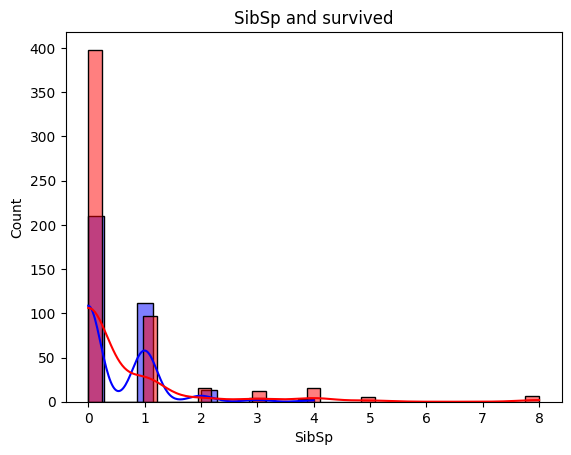

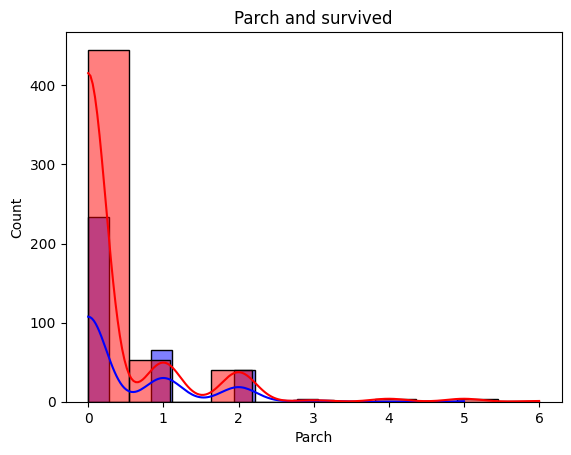

In [22]:
sns.histplot(survived['SibSp'], kde=True, color='blue', label='Survived')
sns.histplot(not_survived['SibSp'], kde=True, color='red', label='Not survived')
plt.title('SibSp and survived')
plt.show()

sns.histplot(survived['Parch'], kde=True, color='blue', label='Survived')
sns.histplot(not_survived['Parch'], kde=True, color='red', label='Not survived')
plt.title('Parch and survived')
plt.show()
# there are emissions, so i drop SibSp >

These are ambiguous features that can be used to calculate the age in the gaps, but for now I will skip these features

So, what do we have?
For first knn-model we take features:
1. Pclass
2. Sex
3. Age

In [24]:
# Make pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

def make_knn_pipeline():
  cat_cols = ['Pclass', 'Sex']
  num_cols = ['Age']

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
  ])

  categorial_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  preprocessor = ColumnTransformer([
      ('num_features', numeric_transformer, num_cols),
      ('cat_features', categorial_transformer, cat_cols),
  ])

  return Pipeline(steps=[
      ('feature_engineering', preprocessor),
      ('classifier', KNeighborsClassifier(5))
  ])

knn_pipeline = make_knn_pipeline()
knn_pipeline.fit(X_train, y_train)
predicted = knn_pipeline.predict(X_test)

submission = pd.DataFrame({'PassengerId': X_test['PassengerId'], 'Survived': predicted})
submission.to_csv(base + '/knn-submission.csv', index=False)
accuracy_score(y_test['Survived'], predicted)

0.8349282296650717